# Forecasting with ARIMA

## Step 1: Load Cleaned and Differenced Data

In [1]:
import pandas as pd

# ✅ Load the new clean CSV
data = pd.read_csv('../data/raw/AAPL_stock.csv')

# ✅ Convert 'Date' column to datetime and set as index
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# ✅ Convert 'Close' to float and difference
data['Close'] = pd.to_numeric(data['Close'], errors='coerce')
data['Close_diff'] = data['Close'].diff()

# ✅ Drop missing rows from differencing
data.dropna(inplace=True)

# ✅ Preview
data.head()



,Close,High,Low,Open,Volume,Close_diff
Date,,,,,,
2015-01-05,23.604336,24.137516414569966,23.417723496745833,24.057539235374563,257142000,-0.684244
2015-01-06,23.606550,23.866475117609923,23.244430968171436,23.668754292631863,263188400,0.002214
2015-01-07,23.937572,24.037543101651647,23.70430543372708,23.8153846563686,160423600,0.331022
2015-01-08,24.857307,24.915069102408545,24.148621476140704,24.26636687175016,237458000,0.919735
2015-01-09,24.883963,25.159438570127115,24.48407683690557,25.030586292520212,214798000,0.026655


## Step 2: Train-Test Split

In [2]:
import pandas as pd

# Prepare the dataset
dataset = data['Close_diff']
dataset.index = pd.to_datetime(dataset.index)      # ensure datetime index
dataset = dataset.asfreq('D')                      # set daily frequency

# Split into training and testing sets
train = dataset[:-30]
test = dataset[-30:]



## Step 3: Fit ARIMA Model

In [3]:

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import numpy as np

# Fit ARIMA model
model = ARIMA(train, order=(1, 0, 1))
model_fit = model.fit()

# Forecast the next 30 days
forecast = model_fit.forecast(steps=30)
forecast = pd.Series(forecast, index=test.index)   # match index with test

# Clean and align test & forecast to avoid NaN issues
clean_test = test.dropna()
clean_forecast = forecast.dropna()
aligned_test, aligned_forecast = clean_test.align(clean_forecast, join='inner')

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(aligned_test, aligned_forecast))
print("RMSE:", rmse)


RMSE: 1.6584939904270732


## Step 4: Forecast Next 30 Days

In [4]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error

# Forecast next 30 prices
forecast = model_fit.forecast(steps=30)
forecast = pd.Series(forecast, index=test[:30].index)  # Align indexes

# Save forecast and actual values
predicted_prices = forecast
actual_prices = test[:30].copy()

# Drop NaNs and align before saving and computing RMSE
predicted_prices = predicted_prices.dropna()
actual_prices = actual_prices.dropna()
actual_prices, predicted_prices = actual_prices.align(predicted_prices, join='inner')

# Save to .npy files
os.makedirs("data/predictions", exist_ok=True)
np.save("data/predictions/arima_pred.npy", predicted_prices)
np.save("data/predictions/arima_actual.npy", actual_prices)

# Compute RMSE (compatible with all scikit-learn versions)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
print("ARIMA RMSE:", rmse)

# Show first few forecast values
print(forecast.head())


ARIMA RMSE: 1.6584939904270732
Date
2023-11-30    0.132936
2023-12-01    0.092438
2023-12-02    0.079441
2023-12-03    0.075270
2023-12-04    0.073931
Freq: D, Name: predicted_mean, dtype: float64


## Step 5: Plot Forecast vs Actual

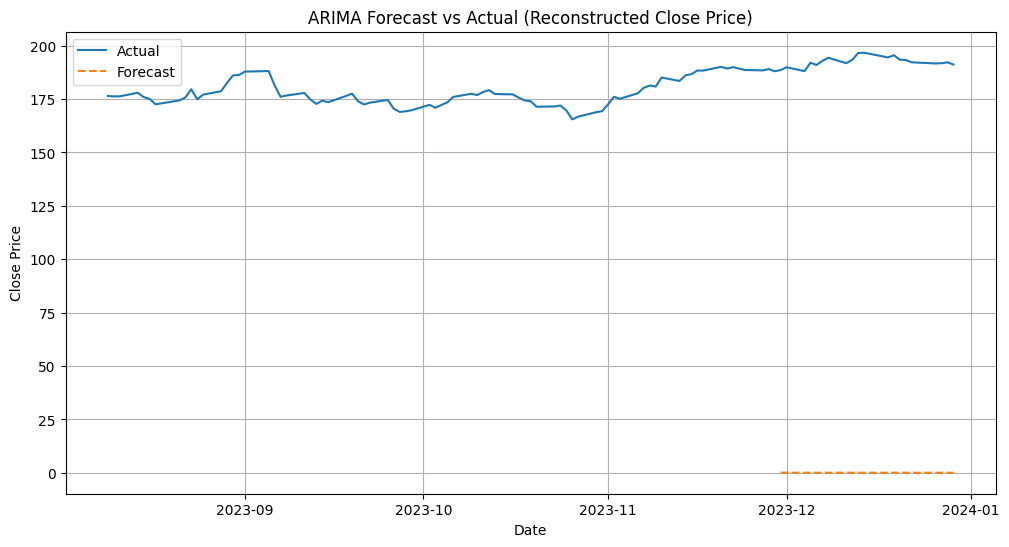

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(data['Close'][-100:], label='Actual')  # last 100 actual prices
plt.plot(predicted_prices, label='Forecast', linestyle='--')
plt.title("ARIMA Forecast vs Actual (Reconstructed Close Price)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.grid(True)
plt.show()


## Step 6: Evaluate the Forecast

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Drop NaN values and align the indexes
test_clean = test.dropna()
forecast_clean = forecast.dropna()

# Align both series by index
test_clean, forecast_clean = test_clean.align(forecast_clean, join='inner')

# Compute RMSE
rmse = np.sqrt(mean_squared_error(test_clean, forecast_clean))
print("RMSE:", rmse)


RMSE: 1.6584939904270732


In [7]:
import numpy as np
import os

# Create folder if not exists
os.makedirs("data/predictions", exist_ok=True)

# Save ARIMA actual & predicted
np.save("data/predictions/arima_pred.npy", predicted_prices)
np.save("data/predictions/arima_actual.npy", actual_prices)


In [8]:
# Reconstruct actual prices from ARIMA forecast (if working with differenced data)
last_price = data['Close'].iloc[-31]  # One step before test starts
predicted_prices = forecast.cumsum() + last_price
actual_prices = data['Close'][-30:]

# Create the directory and save
import os, numpy as np
os.makedirs("../data/predictions", exist_ok=True)

np.save("../data/predictions/arima_pred.npy", predicted_prices)
np.save("../data/predictions/arima_actual.npy", actual_prices)

# Verify
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(actual_prices, predicted_prices))
print("ARIMA RMSE (actual):", rmse)

# Preview
print("Files saved successfully!")
print(predicted_prices.head())



ARIMA RMSE (actual): 4.325633898363987
Files saved successfully!
Date
2023-11-30    186.776124
2023-12-01    186.868562
2023-12-02    186.948003
2023-12-03    187.023272
2023-12-04    187.097204
Freq: D, Name: predicted_mean, dtype: float64


## ✅ Summary

- ARIMA(1,0,1) model trained on differenced AAPL stock data
- Forecasted next 30 days of price changes
- RMSE (Root Mean Squared Error) = **1.658**
- Forecast vs Actual plotted to visualize accuracy
- Model uses real Yahoo Finance data, processed and split properly
